In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
## 读入数据
df = pd.read_csv("商业信贷数据tidy.csv")

## 读入变量数据(哪些变量用于分析)
x_list = pd.read_excel("X_list.xlsx")
X = df[x_list['features'].to_list()] ## 选择必要的列

## 分类变量
categorical_variable = ['emp_title', 'home_ownership', 'verification_status', 'pymnt_plan', 'application_type', 
                         'purpose', 'title', 'zip_code', 'addr_state', 'hardship_flag', 'disbursement_method',
                         'term']
## 连续变量
continue_variable = list(set(X.columns) - set(categorical_variable))

## n个类别的分类变量生成n-1个虚拟变量
for column in categorical_variable:
    ## term 是2分类变量, 不用生成虚拟变量
    if column == 'term':
        continue
    X = pd.concat([X, pd.get_dummies(X[column], prefix = column, drop_first = True)], axis = 1)

## 删除掉原变量
X.drop(columns = categorical_variable, inplace = True)

## 一个贷款状态的映射字典
status_dic = {'Fully Paid' : 0, 'Charged Off' : 1, 'Late (31-120 days)' : 1, 'In Grace Period' : 1,
              'Late (16-30 days)' : 1, 'Default' : 1}
## 将字符串映射成数值
df['loan_status'] = df['loan_status'].map(status_dic)
y = df['loan_status']

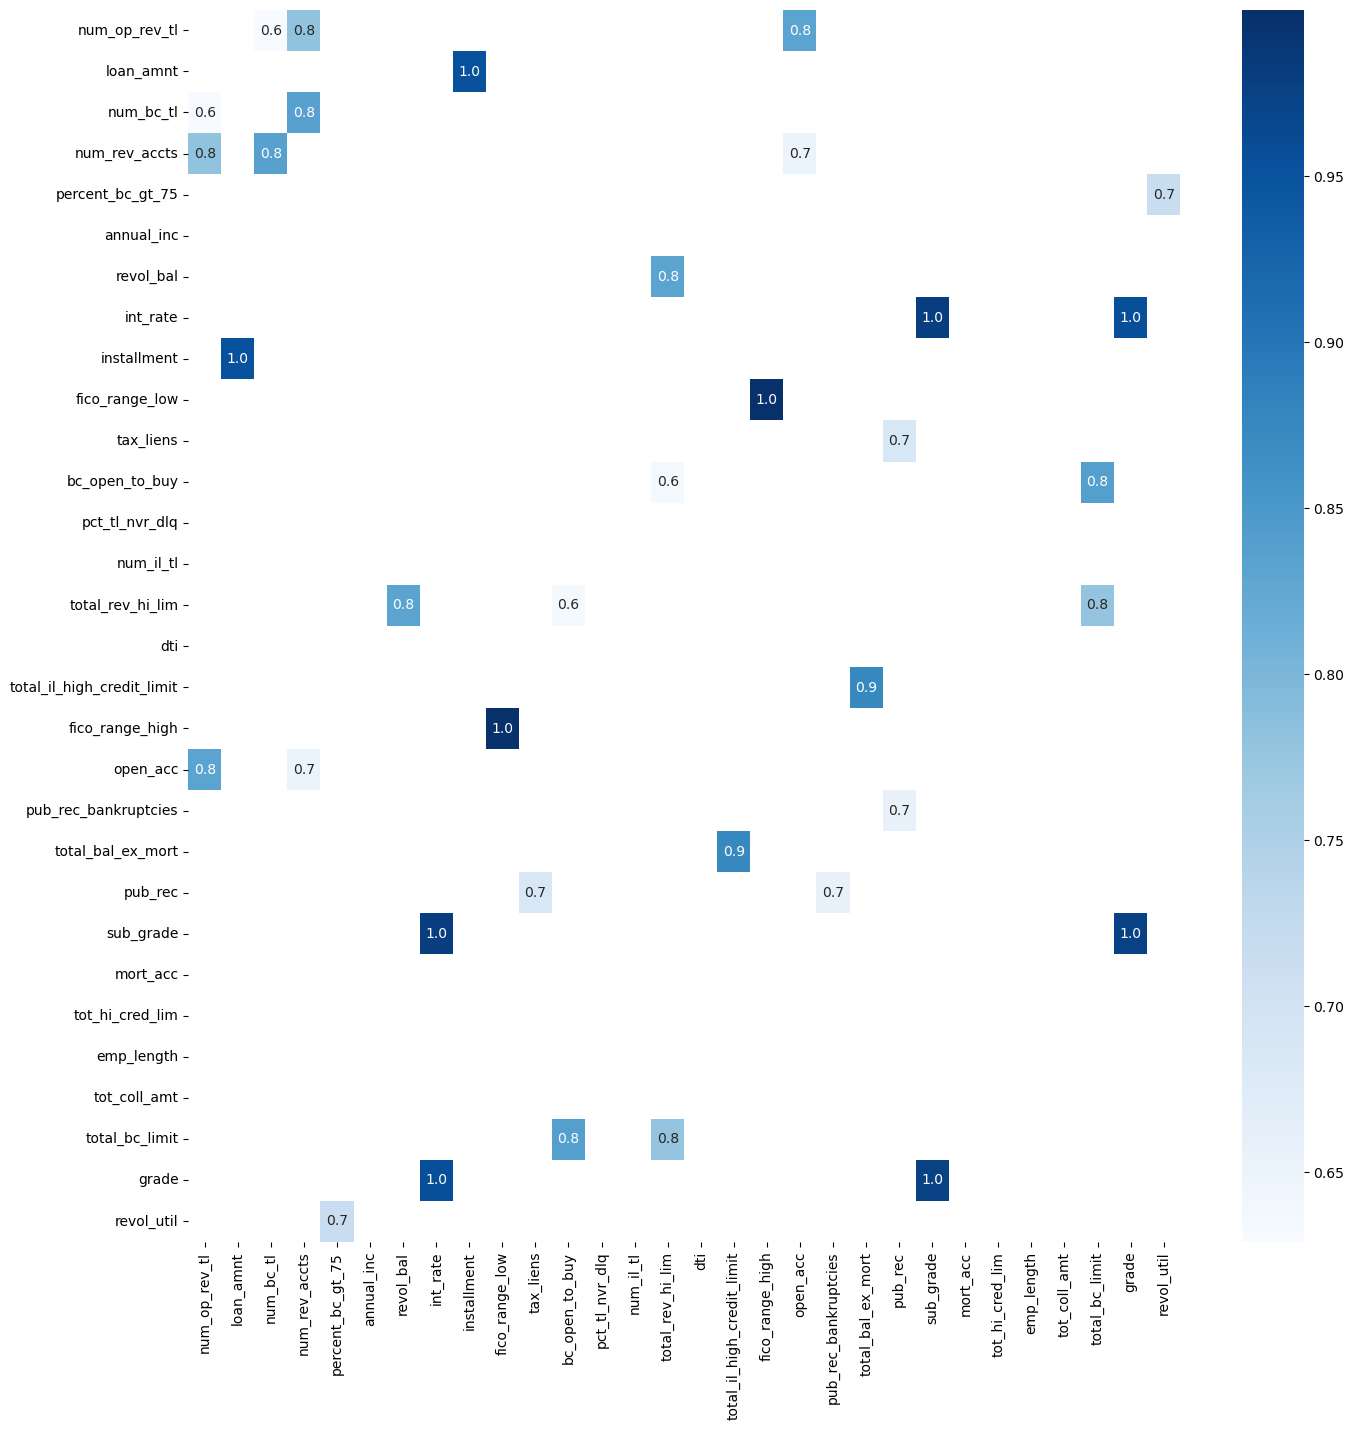

In [3]:
## 查看变量之间的线性相关关系，只可视化线性相关关系大于等于0.6的
plt.figure(figsize = (16, 16))
sns.heatmap(X[continue_variable].corr(),
            mask = (X[continue_variable].corr() < 0.6) | (X[continue_variable].corr() == 1),
            annot=True, fmt=".1f",
            cmap="Blues")
plt.savefig("Corr_heatmap.jpg", dpi = 1000)
plt.show()

In [4]:
## 去掉线性相关系数大于等于0.8的变量

## grade 和 sub_grade, int_rate 共线性
## loan_amnt 和 installment 共线性
## fico_range_low 和 fico_range_high 共线性
## bc_open_to_buy 和 total_bc_limit 共线性
## total_bal_ex_mort 和 total_li_high_credit_limit 共线性
## num_op_rev_tl 和 open_acc, num_rev_accts 共线性
## total_rev_hi_lim 和 revol_bal, total_bc_limit 共线性
## num_rev_accts 和 num_bc_tl, num_op_rev_tl 共线性
drop_columns = ["sub_grade", "int_rate", "installment", "fico_range_high", "total_bc_limit", "total_il_high_credit_limit", "num_op_rev_tl", "total_rev_hi_lim",
                "num_rev_accts"]
## 去掉共线性变量
X.drop(columns = drop_columns, inplace = True)
## 更新连续变量
continue_variable = list(set(continue_variable) - set(drop_columns))

In [5]:
## 划分训练集、验证集、测试集
x_train_valid, x_test, y_train_valid, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123,
                                                                stratify = y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size = 0.1 ,random_state = 123,
                                                      stratify = y_train_valid)

## 标准化数据！！！ 便于后期比较各变量之间的重要性

## =============================================================================================  ##
## 标准化数据要防止信息泄漏, 用验证集找最优参数, 那么跑训练集数据的时候, 标准化只能用训练集的数据, 不能包括验证集. ##
## 用验证集去测试用训练集跑出来的模型, 也要用同样的处理方式先处理, 即利用训练集的均值和标准差去进行标准化.        ##
## 测试集是同理的, 当找出最优参数后, 用训练集和验证集的数据一起跑模型, 标准化用的是这两个集合的数据, 不包括训练集. ##
## =============================================================================================  ##

## 计算训练集数据的均值和标准差
train_mu_continue =  np.mean(x_train[continue_variable], axis = 0)
train_std_continue = np.std(x_train[continue_variable], axis = 0)

## 标准化训练集和验证集数据
x_train[continue_variable] = (x_train[continue_variable] - train_mu_continue) / train_std_continue
x_valid[continue_variable] = (x_valid[continue_variable] - train_mu_continue) / train_std_continue

In [6]:
## 确定参数的搜索范围
alphas = np.append(np.linspace(0, 1, 50), np.linspace(1, 500, 50))
precision = [[], []]  ## 用于存放precision数据
recall = [[], []]  ## 用于存放recall数据
f1scores = [[], []] ## 用于存放 f1score数据

## 遍历两种solver方法
for idx1, solver in enumerate(['liblinear', 'saga']):
    for alpha in alphas:
        ## logisticRegresson + l1 penalty
        logistic_model = LogisticRegression(penalty = 'l1', C = 1 / alpha , solver = solver, n_jobs = 8, random_state = 123)
        logistic_model.fit(x_train, y_train) ## 训练集上训练模型
        y_pre = logistic_model.predict(x_valid) ## 用验证集进行测试
        precision[idx1] = np.append(precision[idx1], logistic_model.score(x_valid, y_valid)) ## 计算precision
        recall[idx1] = np.append(recall[idx1], recall_score(y_valid, y_pre)) ## 计算recall
        f1scores[idx1] = np.append(f1scores[idx1], f1_score(y_valid, y_pre)) ## 计算f1score

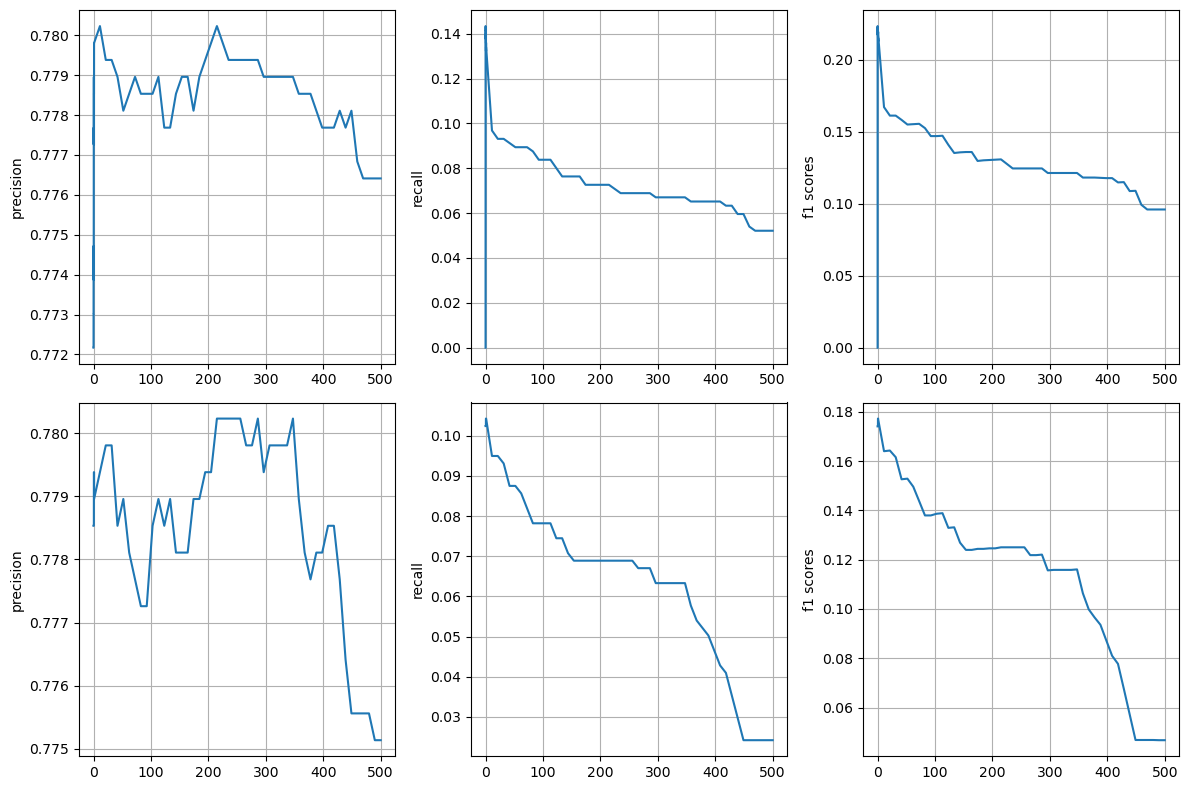

In [7]:
## 可视化上述最优参数搜寻结果
## 一共6幅图，2行，每行3幅图，3幅图分别为precision、 recall、 f1 score

results = [precision, recall ,f1scores]
ylabels = ['precision', 'recall', 'f1 scores']
step = 1
plt.figure(figsize = (12, 8))
for i in range(2):
    for j in range(3):
        plt.subplot(2, 3, step)
        plt.plot(alphas, results[j][i])
        plt.ylabel(ylabels[j])
        plt.grid()
        step += 1
plt.tight_layout()
plt.savefig("Logistic_lasso_search_alpha_1.jpg", dpi = 1000)

In [8]:
print("Based accuracy:{}".format(alphas[np.argmax(precision[0])]))
print("Based recall:{}".format(alphas[np.argmax(recall[0])]))
print("Based f1_score:{}".format(alphas[np.argmax(f1scores[0])]))

Based accuracy:11.183673469387756
Based recall:0.02040816326530612
Based f1_score:0.08163265306122448


In [9]:
## 基于solver = liblinear的方法进行进一步的最优参数搜寻
alphas = np.linspace(0.02, 0.2, 100)
precision = []
recall = []
f1scores = []
for alpha in alphas:
    logistic_model = LogisticRegression(penalty = 'l1', C = 1 / alpha , solver = 'liblinear', n_jobs = 8, random_state = 123)
    logistic_model.fit(x_train, y_train)
    y_pre = logistic_model.predict(x_valid)
    precision = np.append(precision, logistic_model.score(x_valid, y_valid))
    recall = np.append(recall, recall_score(y_valid, y_pre))
    f1scores = np.append(f1scores, f1_score(y_valid, y_pre))

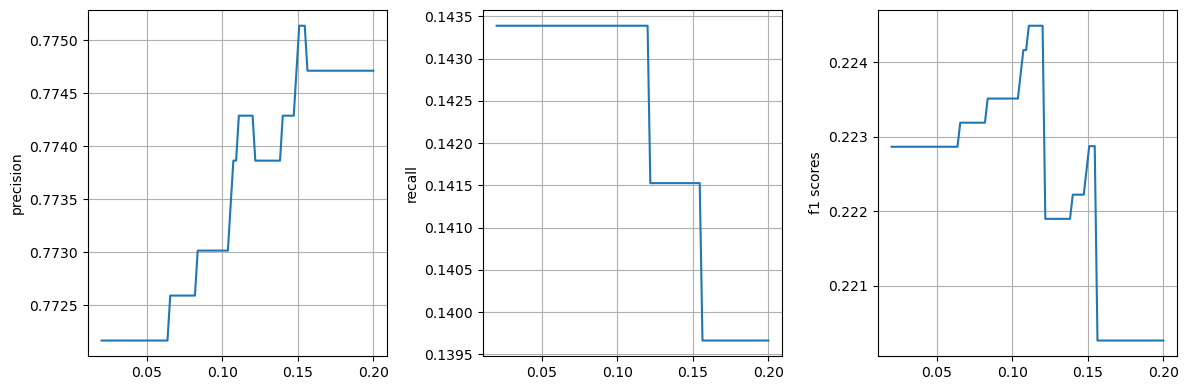

In [10]:
## 可视化结果
results = [precision, recall ,f1scores]
ylabels = ['precision', 'recall', 'f1 scores']
step = 1
plt.figure(figsize = (12, 4))
for j in range(3):
    plt.subplot(1, 3, step)
    plt.plot(alphas, results[j])
    plt.ylabel(ylabels[j])
    plt.grid()
    step += 1
plt.tight_layout()
plt.savefig("Logistic_lasso_search_alpha_2.jpg", dpi = 1000)

In [11]:
print("Based accuracy:{}".format(alphas[np.argmax(precision)]))
print("Based recall:{}".format(alphas[np.argmax(recall)]))
print("Based f1_score:{}".format(alphas[np.argmax(f1scores)]))

Based accuracy:0.1509090909090909
Based recall:0.02
Based f1_score:0.11090909090909093


In [12]:
## 利用训练集和验证集的数据训练模型，用测试集的数据测试模型
## 计算训练集和验证集两个集合数据的均值和标准差
train_valid_mu_continue =  np.mean(x_train_valid[continue_variable], axis = 0)
train_valid_std_continue = np.std(x_train_valid[continue_variable], axis = 0)

## 标准化训练集+验证集、测试集
x_train_valid[continue_variable] = (x_train_valid[continue_variable] - train_valid_mu_continue) / train_valid_std_continue
x_test[continue_variable] = (x_test[continue_variable] - train_valid_mu_continue) / train_valid_std_continue

## 采用最优参数训练模型
logistic_model = LogisticRegression(penalty = 'l1', C = 1 / alphas[np.argmax(f1scores)] , solver = 'liblinear', n_jobs = 8, random_state = 123)
logistic_model.fit(x_train_valid, y_train_valid)
## 用测试集去做测试
y_test_pre = logistic_model.predict(x_test)
print('precision of test set: {}'.format(logistic_model.score(x_test, y_test)))
print('recall of test set: {}'.format(recall_score(y_test, y_test_pre)))
print('f1score of test set: {}'.format(f1_score(y_test, y_test_pre)))

precision of test set: 0.7663329373833362
recall of test set: 0.13104988830975428
f1score of test set: 0.20358588779641415


In [13]:
## 混淆矩阵
confusion_matrix(y_test, y_test_pre)

array([[4340,  210],
       [1167,  176]])

In [14]:
## 利用整个数据集去跑模型，用来测试各个变量对违约预测的影响程度
## 计算均值和标准差
X_mu_continue =  np.mean(X[continue_variable], axis = 0)
X_std_continue = np.std(X[continue_variable], axis = 0)

## 标准化s数据
X[continue_variable] = (X[continue_variable] - X_mu_continue) / X_std_continue

## 训练模型
logistic_model = LogisticRegression(penalty = 'l1', C = 1 / alphas[np.argmax(f1scores)] , solver = 'liblinear', n_jobs = 8, random_state = 123)
logistic_model.fit(X, y)
y_pre = logistic_model.predict(X)
print('precision of data set: {}'.format(logistic_model.score(X, y)))
print('recall of data set: {}'.format(recall_score(y, y_pre)))
print('f1score of data set: {}'.format(f1_score(y, y_pre)))

precision of data set: 0.7832535722770934
recall of data set: 0.15711094564408043
f1score of data set: 0.2483521657250471


In [15]:
## 混淆矩阵
confusion_matrix(y, y_pre)

array([[22022,   726],
       [ 5660,  1055]])

In [16]:
## 获取各个变量的回归系数
feature_coef = pd.DataFrame({'features' : logistic_model.feature_names_in_, 'coef' : logistic_model.coef_[0]})
## 保存文件
feature_coef.to_excel("logistic_lasso_coef.xlsx", index = False)

## 连续变量和分类变量应该分开比较, 连续变量经过标准化之后是能进行互相比较, 分类变量只能和其基准组进行比较

## 获取连续变量的回归系数
continue_feature_coef = feature_coef[feature_coef['features'].isin(continue_variable)]
continue_feature_coef.to_excel("logistic_lasso_coef_continue.xlsx", index = False)

## 获取分类变量的回归系数
discrete_feature_coef = feature_coef[~feature_coef['features'].isin(continue_variable)]
discrete_feature_coef.to_excel("logistic_lasso_coef_discrete.xlsx", index = False)

## 按照从小到大进行排序
continue_feature_coef.sort_values(by = 'coef', inplace = True)
discrete_feature_coef.sort_values(by = 'coef', inplace = True)
discrete_feature_coef.reset_index(drop = True, inplace = True)

In [17]:
## 生成一个绝对重要程度(回归系数)的列
discrete_feature_coef['abs_coef'] = np.abs(discrete_feature_coef['coef'])

## 获取每个分类变量前10重要的列(绝对重要程度前10大)
indices = []  ## 用于储存系数
for cate_var in categorical_variable:
    cate_var = cate_var.split('_')[0]
    indices += list((discrete_feature_coef[discrete_feature_coef['features'].str.contains(cate_var)]['abs_coef']).sort_values(ascending = False).index[1 : 10])
## 选取这些变量
discrete_feature_coef = discrete_feature_coef.loc[indices, ['features', 'coef']]
## 排序
discrete_feature_coef.sort_values(by = 'coef', inplace = True)

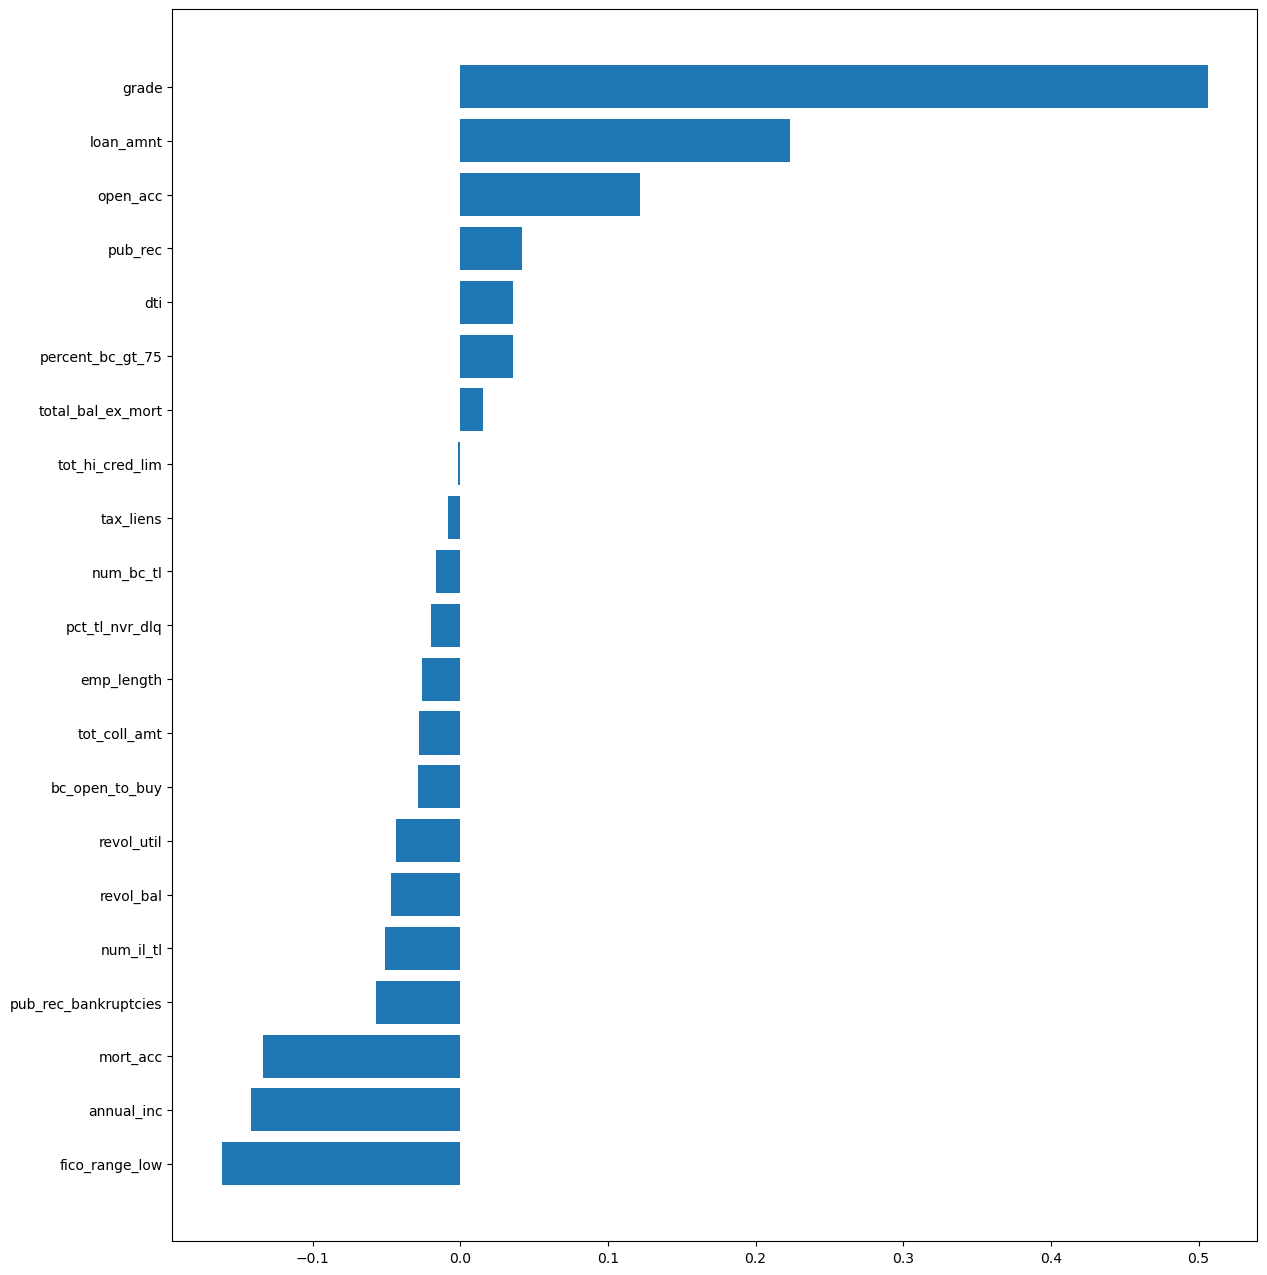

In [18]:
plt.figure(figsize = (14, 16))
plt.barh(y = continue_feature_coef['features'], width = continue_feature_coef['coef'])
# plt.figure(figsize = (16, 6))
# plt.bar(x = continue_feature_coef['features'], height = continue_feature_coef['coef'])
# plt.xticks(rotation = 90)
plt.savefig("Logistic_lasso_continue_coef_importance.jpg", dpi = 1000)
plt.show()

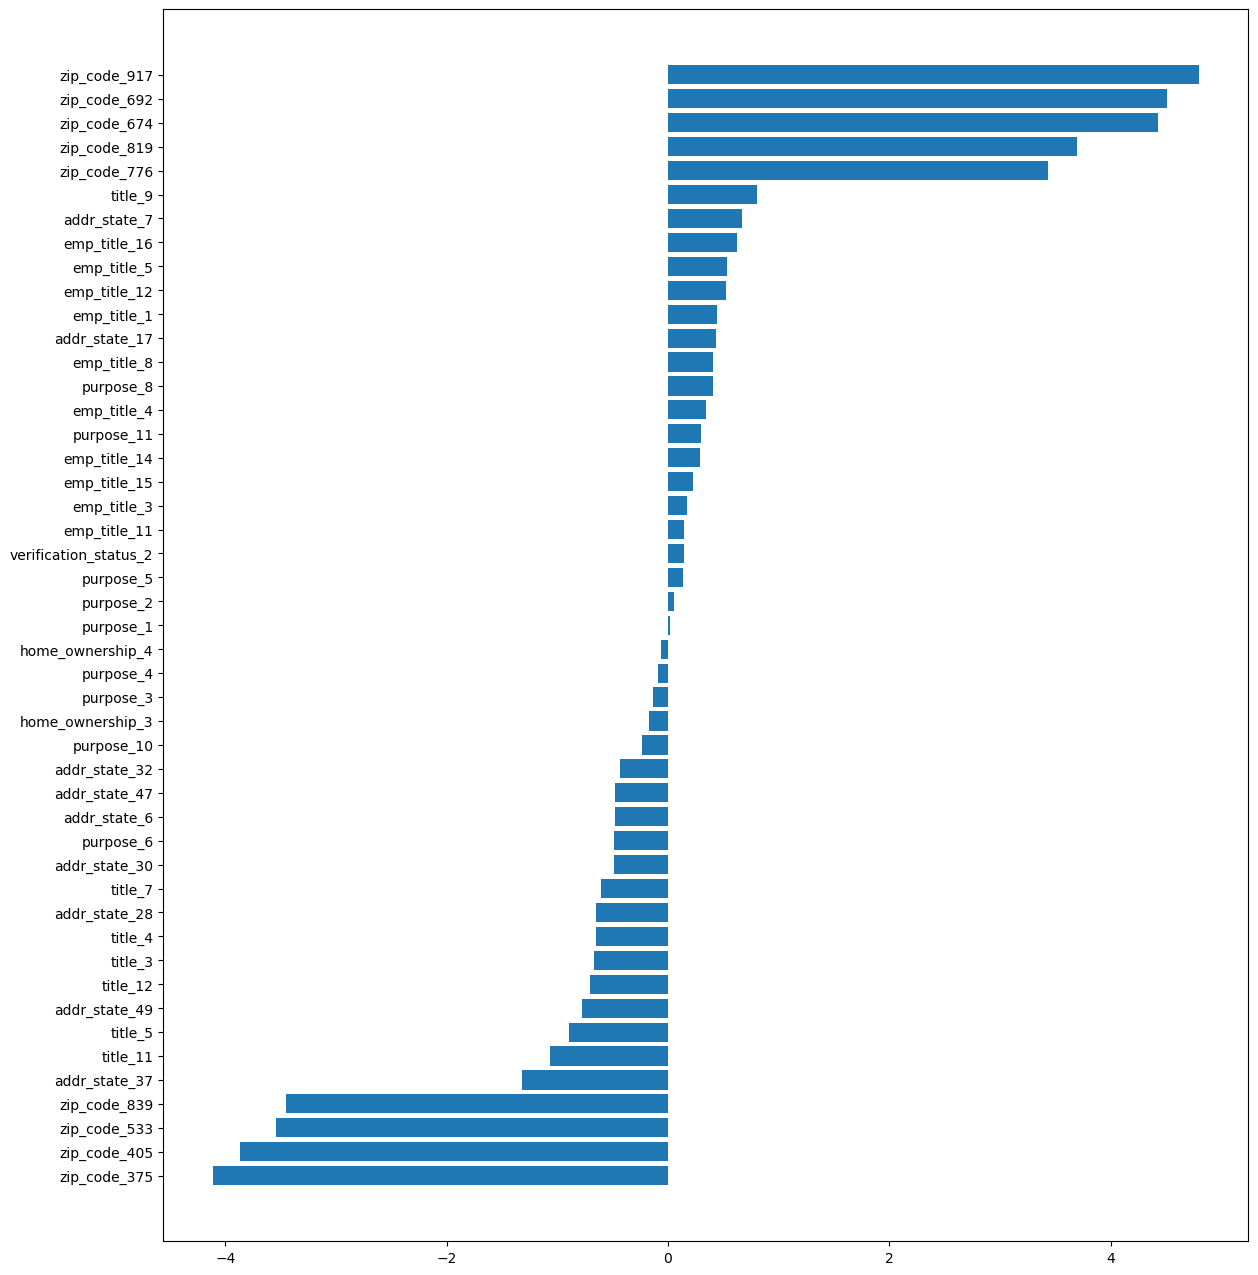

In [19]:
plt.figure(figsize = (14, 16))
plt.barh(y = discrete_feature_coef['features'], width = discrete_feature_coef['coef'])

# plt.figure(figsize = (16, 6))
# plt.bar(x = discrete_feature_coef['features'], height = discrete_feature_coef['coef'])
# plt.xticks(rotation = 90)
plt.savefig("Logistic_lasso_discrete_coef_importance.jpg", dpi = 1000)
plt.show()